# imports

In [3]:
# ==========================
# 1. 標準庫
# ==========================
import sys
import os
import io
import json
import glob
import datetime
import random
from pathlib import Path
from typing import Dict, List, Union, Callable, Optional, Tuple

# ==========================
# 2. 第三方套件
# ==========================
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import trange
from IPython.display import clear_output, display, HTML
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
from torchsummary import summary

# import cv2  # 如果影片相關再啟用

# ==========================
# 3. 專案設定
# ==========================
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# ==========================
# 4. IPython 魔法指令 (Jupyter 專用)
# ==========================
%reload_ext autoreload
%autoreload 2

# ==========================
# 5. 專案自定義函式庫
# ==========================
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)


# from core_utils.utils_io import (
#     np2pil,      # numpy → PIL Image
#     imwrite,     # 儲存圖像為檔案
#     imencode,    # 編碼圖像為 byte stream
#     im2url,      # 圖像轉 base64 URL（HTML 顯示用）
#     load_emoji,   # 載入 emoji 圖像
#     load_cfd_npy
# )

# from core_utils.utils_image import (
#     imshow,      # 在 notebook 顯示圖像
#     tile2d,      # 多圖拼接
#     zoom         # 放大圖像
# )

# from core_utils.utils_video import (
#     save_video,  # 批次輸出影片
#     VideoWriter  # 逐幀寫入影片（支援 context manager）
# )

# from core_utils.ops_tf_np import (
#     to_rgb,
#     to_rgba,
#     to_alpha,
#     crop_and_resize,
#     get_random_cfd_slices,
#     get_random_cfd_slices_pair
# )


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E4_PI_NCA.utils.helper import (
    to_HWC,
    print_tensor_stats,
    split_cases
)

clear_output()

# global params

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def get_output_path(Suffix :str = None) -> str:
    """
    建立輸出資料夾
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if Suffix:
        path = f"../outputs/E4-2_PI-NCA_{timestamp}/{Suffix}"
    else:
        path = f"../outputs/E4-2_PI-NCA_{timestamp}"
    output_path = Path(path)
    output_path.mkdir(parents=True, exist_ok=True)
    return str(output_path)

# dataset params
CASE_DATA = np.load("../dataset/all_cases.npz", allow_pickle=True)
EPOCH_POOL_SIZE = 16
IMG_SIZE = 96

# model params
CHANNELS = 20

# trainning params
TOTAL_EPOCHS = 200
TRAIN_BATCH_SIZE = 8
EPOCH_ITEM_REPEAT_NUM = 4
REPEAT_NUM_PER_EPOCH = 1
ROLLOUT_MIN = 1
ROLLOUT_MAX = 8


Using device: cuda


In [5]:
def set_global_seed(seed: int = 42) -> None:
    """
    設定 Python、NumPy、PyTorch 的隨機種子，確保結果可重現。

    Parameters
    ----------
    seed : int, optional
        隨機種子數值, 預設 42
    """
    # Python random
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch CPU
    torch.manual_seed(seed)
    
    # PyTorch CUDA (單GPU & 多GPU)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # 設定 cudnn 為 deterministic，確保卷積結果可重現
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Global seed set to {seed}")

set_global_seed(1234)

[INFO] Global seed set to 1234


# helper functions

In [6]:
def process_case_data_to_tensor_list(
        case_data: Union[np.ndarray, np.lib.npyio.NpzFile, list]=CASE_DATA,
        channels_n: int = CHANNELS
        ) -> List[torch.Tensor]:
    """
    將整個 case_data 轉成 list of 0-1 torch.Tensor，shape = (channels_n, H, W)
    支援輸入 np.ndarray (B,C,H,W), npzfile 或 list of arrays
    """
    case_list = []

    # 將 npzfile 或單一 array 轉成 list of arrays
    if isinstance(case_data, np.lib.npyio.NpzFile):
        keys = list(case_data.files)
        arrays = [case_data[k] for k in keys]
    elif isinstance(case_data, np.ndarray):
        if case_data.ndim == 4:  # B,C,H,W
            arrays = [case_data[i] for i in range(case_data.shape[0])]
        else:  # C,H,W
            arrays = [case_data]
    elif isinstance(case_data, list):
        arrays = case_data
    else:
        raise ValueError(f"Unsupported case_data type: {type(case_data)}")

    for arr in arrays:
        if isinstance(arr, torch.Tensor):
            arr = arr.cpu().numpy()
        else:
            arr = arr.astype(np.float32)

        C, H, W = arr.shape
        # 補零到目標 channels
        if C < channels_n:
            pad = np.zeros((channels_n - C, H, W), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        case_tensor = torch.tensor(arr, dtype=torch.float32, device=DEVICE)
        case_list.append(case_tensor)

    return case_list



In [7]:
all_cases = process_case_data_to_tensor_list()

TRAIN_CASES, EVAL_CASES, TEST_CASES = split_cases(all_cases, 
                                                  train_ratio=0.7, 
                                                  eval_ratio=0.2, 
                                                  test_ratio=0.1)
print(len(TRAIN_CASES), len(EVAL_CASES), len(TEST_CASES))


4 1 1


In [8]:
def create_epoch_pool(
    train_case_list: List[torch.Tensor] = TEST_CASES,
    eval_case_list: Optional[List[torch.Tensor]] = EVAL_CASES,
    test_case_list: Optional[List[torch.Tensor]] = TEST_CASES,
    poolsize: int = EPOCH_POOL_SIZE,
    hw_size: int = IMG_SIZE,
    mode: str = 'train',  # 'train', 'eval', 'test'
    eval_full_image_prob: float = 0.2  # 評估時使用 full image 的機率
) -> torch.Tensor:
    """
    從指定的 case list 隨機生成一個 pool，每個樣本為裁剪的子區域或 full image。

    參數
    ----------
    train_case_list : List[torch.Tensor]
        訓練 case，每個 shape=(channels_n,H,W)
    eval_case_list : Optional[List[torch.Tensor]], default None
        驗證 case，每個 shape=(channels_n,H,W)，mode='eval' 才會使用
    test_case_list : Optional[List[torch.Tensor]], default None
        測試 case，每個 shape=(channels_n,H,W)，mode='test' 才會使用
    poolsize : int, default EPOCH_POOL_SIZE
        pool 中樣本數量
    hw_size : int, default IMG_SIZE
        裁剪區域大小，訓練模式固定使用
    mode : str, default 'train'
        模式：'train', 'eval', 'test'
    eval_full_image_prob : float, default 0.5
        評估模式時使用 full image 的機率

    回傳
    ----------
    torch.Tensor
        shape = (poolsize, channels_n, h_crop, w_crop)
        測試模式直接使用 full image
    """
    # 選擇對應 case list
    if mode == 'train':
        case_list = train_case_list
    elif mode == 'eval':
        if eval_case_list is None:
            raise ValueError("mode='eval' 需要提供 eval_case_list")
        case_list = eval_case_list
    elif mode == 'test':
        if test_case_list is None:
            raise ValueError("mode='test' 需要提供 test_case_list")
        case_list = test_case_list
        poolsize = 1  # 測試模式固定只取 1 個 sample
    else:
        raise ValueError(f"未知 mode='{mode}'，請選擇 'train', 'eval', 'test'")

    B = len(case_list)
    C, H, W = case_list[0].shape
    pool = []
    eval_fullsize_possibilities = np.random.rand()
    eval_size = np.random.randint(hw_size, H)
    for _ in range(poolsize):
        # 隨機選一個 case
        b_idx = np.random.randint(0, B)
        arr_tensor = case_list[b_idx]

        # # 決定裁剪大小
        # if mode == 'train':
        #     hw_crop = hw_size
        # elif mode == 'eval':
        #     # 隨機裁剪或使用 full image
        #     if eval_fullsize_possibilities < eval_full_image_prob:
        #         hw_crop = H  # full image
        #     else:
        #         hw_crop = eval_size
        # else:  # test
        #     hw_crop = H  # full image
        hw_crop = hw_size
        # 隨機裁剪起始位置
        h_start = 0 if hw_crop == H else np.random.randint(0, H - hw_crop + 1)
        w_start = 0 if hw_crop == W else np.random.randint(0, W - hw_crop + 1)
        sub = arr_tensor[:, h_start:h_start + hw_crop, w_start:w_start + hw_crop]

        pool.append(sub)

    pool_tensor = torch.stack(pool, dim=0)  # shape = (poolsize, channels_n, hw_crop, hw_crop)
    return pool_tensor


In [9]:
def init_X(target: torch.Tensor) -> torch.Tensor:
    """
    根據 target 初始化 X，形狀相同 (CHW 或 BCHW)。
    每個 pixel 位置依照最後一個 channel 判斷：
        - 最後 channel = 0 -> 該 pixel 所有 channel = 0
        - 否則 -> 該 pixel 所有 channel = 1

    Parameters
    ----------
    target : torch.Tensor
        shape = (C, H, W) 或 (B, C, H, W)

    Returns
    -------
    torch.Tensor
        與 target 同 shape 的 tensor，值為 0 或 1 (float32)
    """
    X = torch.ones_like(target, dtype=torch.float32)

    if target.ndim == 3:
        # CHW
        mask = target[-1, :, :] == 0  # (H, W)
        X[:, mask] = 0

    elif target.ndim == 4:
        # BCHW
        mask = target[:, -1, :, :] == 0  # (B, H, W)
        B, C, H, W = target.shape
        mask_exp = mask.unsqueeze(1).expand(B, C, H, W)  # broadcast 到 C 維
        X[mask_exp] = 0

    else:
        raise ValueError(f"不支援維度 {target.ndim}, 只支援 CHW 或 BCHW")

    return X


# viz load data

In [10]:
Y_pool = create_epoch_pool()
X_pool = init_X(Y_pool)
print("Epoch pool shape:", Y_pool.shape)  # (poolsize, hw_size, hw_size, 6)
print_tensor_stats(Y_pool, "Y Pool")



Epoch pool shape: torch.Size([16, 20, 96, 96])
Y Pool (B,C,H,W) shape = torch.Size([16, 20, 96, 96])
  channel 0: min=0.000000, max=0.810026
  channel 1: min=0.104777, max=0.806498
  channel 2: min=0.000000, max=0.629894
  channel 3: min=0.000000, max=1.000000
  channel 4: min=0.151400, max=0.781837
  channel 5: min=0.000000, max=1.000000
  channel 6: min=0.000000, max=1.000000
  channel 7: min=0.000000, max=0.000000
  channel 8: min=0.000000, max=0.000000
  channel 9: min=0.000000, max=0.000000
  channel 10: min=0.000000, max=0.000000
  channel 11: min=0.000000, max=0.000000
  channel 12: min=0.000000, max=0.000000
  channel 13: min=0.000000, max=0.000000
  channel 14: min=0.000000, max=0.000000
  channel 15: min=0.000000, max=0.000000
  channel 16: min=0.000000, max=0.000000
  channel 17: min=0.000000, max=0.000000
  channel 18: min=0.000000, max=0.000000
  channel 19: min=0.000000, max=0.000000


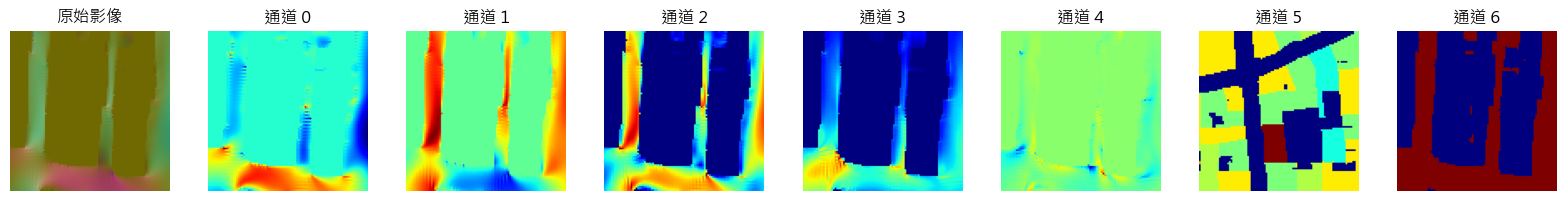

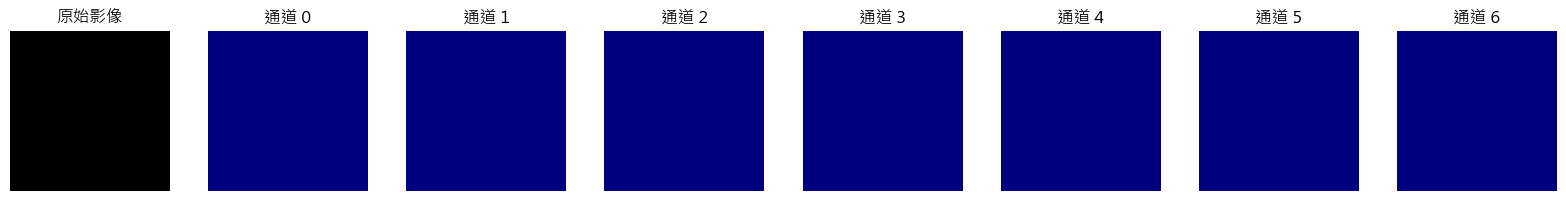

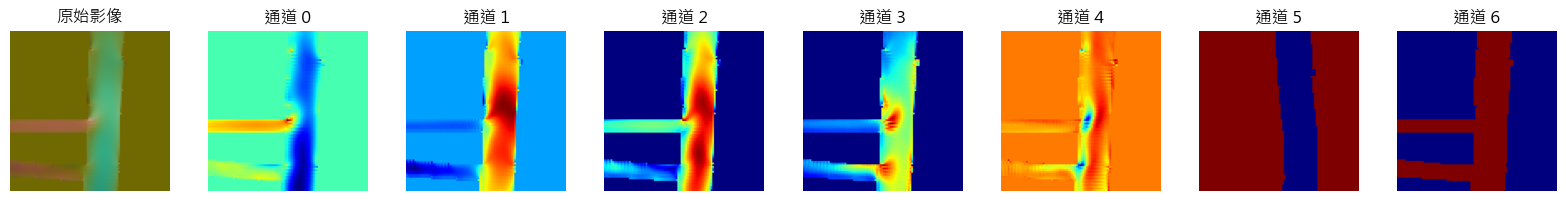

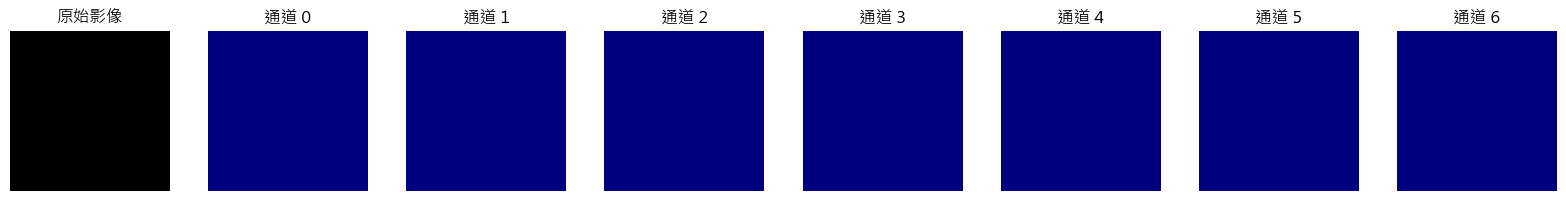

In [11]:
for i in range(2):
    plt_HWC_split_channels(to_HWC(Y_pool[i,:7,...]))  # 顯示 pool 中隨機一個樣本的各 channel
    plt_HWC_split_channels(to_HWC(X_pool[i,:7,...]))

# define Neural Net

## model

In [12]:
def set_kernels(angle: float = 0.0, device: str = "cpu") -> torch.Tensor:
    """
    建立 NCA 用的基本卷積核，包含 identity, dx, dy (旋轉後)
    
    Parameters
    ----------
    angle : float, optional
        kernel 旋轉角度, 預設 0
    device : str, optional
        放置張量的裝置, 預設 "cpu"
    
    Returns
    -------
    torch.Tensor
        shape = (3, 3, 3)，三個 kernel
    """
    identify = torch.tensor([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ], dtype=torch.float32, device=device)

    dx = torch.tensor([
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]
    ], dtype=torch.float32, device=device) / 8.0

    dy = dx.t()

    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    kernel = torch.stack([
        identify,
        c * dx - s * dy,
        s * dx + c * dy
    ], dim=0)   # [3, 3, 3]

    return kernel

In [ ]:
class CAModel(nn.Module):
    def __init__(self, channel_n: int = CHANNELS, kernel_count: int = 3):
        """
        Neural Cellular Automata 模型

        Parameters
        ----------
        channel_n : int
            channel 數量
        kernel_count : int
            kernel 個數 (通常為 3: identity, dx, dy)
        """
        super().__init__()
        self.channel_n = channel_n
        self.kernel_count = kernel_count

        # ===== rule block =====
        # 直接寫在 CAModel 裡，包含 residual 與多層卷積
        hidden_dim = 128
        self.rule_block = nn.Sequential(
            nn.Conv2d(channel_n * kernel_count, hidden_dim, kernel_size=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, channel_n, kernel_size=1, bias=False)
        )
    def perceive_block(self, x: torch.Tensor, angle: float = 0.0) -> torch.Tensor:
        """
        感知 (perceive) block: 對每個 channel 套用多個卷積核

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        angle : float, optional
            kernel 旋轉角度, 預設 0

        Returns
        -------
        torch.Tensor
            shape = (B, C * kernel_count, H, W)
        """
        b, c, h, w = x.shape
        device = x.device

        base_kernel = set_kernels(angle=angle, device=device)  # (3, 3, 3)
        kernel = base_kernel.unsqueeze(1).repeat(c, 1, 1, 1)   # (3*C, 1, 3, 3)

        # depthwise conv (groups = c)
        y = F.conv2d(x, kernel, padding=1, groups=c)  # (B, C*3, H, W)
        return y

    def forward_pass(self, x: torch.Tensor, angle: float = 0.0) -> torch.Tensor:
        """
        單步更新

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        angle : float, optional
            kernel 旋轉角度

        Returns
        -------
        torch.Tensor
            更新後的張量, shape = (B, C, H, W)
        """
        # print("Input shape:", x.shape)
        y = self.perceive_block(x, angle)
        # print("Perceived shape:", y.shape)
        dx = self.rule_block(y)
        # print("Delta shape:", dx.shape)
        b, c, h, w = y.shape
        # udpate_mask = (torch.rand(b, 1, h, w, device=DEVICE)+0.8).floor()
        # 只在 mask 為 1 的位置更新
        mask = x[:, 6:7, :, :]             # 最後一個 channel作為 mask
        updated = x[:, :, :, :] + dx * mask
        return torch.cat([updated, mask], dim=1)

    def forward(self, x: torch.Tensor, n_times: int = 1) -> torch.Tensor:
        """
        多步迭代

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        n_times : int
            更新次數

        Returns
        -------
        torch.Tensor
            shape = (B, C, H, W)
        """
        for _ in range(n_times):
            x = self.forward_pass(x)
        return x

model = CAModel(channel_n=CHANNELS).to(DEVICE)
summary(model, (CHANNELS, IMG_SIZE, IMG_SIZE), device=DEVICE)


RuntimeError: The size of tensor a (19) must match the size of tensor b (20) at non-singleton dimension 1

cases : cfd les sim but time average 
epoch_pool : sample from cases and get (batch,channel, h, w) 
item_pool : repeat epoch_pool n times to get (batch*n ,channel, h, w) and store temp data while training
train_batch : actual train batch to run in model (8,c,h,w)
iter_count : how many times to iter all batch once in item_pool (batch*n)/train_batch_size 
repeat_times: default 1


training strategies :

for epoch in epoch_count:
    create new epoch_pool
    for i in iter_count*repeat_times
        train_batch = item_pool[i*train_batch_size: i*train_batch_size+i*train_batch_size, :,:,:]
        pass train_batch forward model random (0,32) times then bptt


## epoch step

### train step

In [ ]:
# ====== 訓練函式 ======
def train_one_epoch(
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    train_batch_size: int = TRAIN_BATCH_SIZE,
    item_pool_repeats: int = EPOCH_ITEM_REPEAT_NUM,
    repeats_per_epoch: int = REPEAT_NUM_PER_EPOCH,
    rollout_min: int = ROLLOUT_MIN,
    rollout_max: int = ROLLOUT_MAX
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    執行一個 epoch 的訓練迴圈，回傳最後一個 batch 的 loss 與對應資料。

    參數:
        model: nn.Module, 神經網路模型
        optimizer: PyTorch Optimizer
        loss_fn: nn.Module, 損失函數
        train_batch_size: int, 單次訓練的 batch 大小
        item_pool_repeats: int, 將 epoch pool 複製的次數
        repeats_per_epoch: int, 每個 epoch 重複迭代的次數
        rollout_min: int, 最小演化步數
        rollout_max: int, 最大演化步數

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """
    model.train()

    # 建立 epoch 的子區域池
    epoch_pool = create_epoch_pool(mode="train").to(DEVICE)
    

    # 複製 item pool
    epoch_pool_extended = epoch_pool.repeat((item_pool_repeats, 1, 1, 1))
    pool_size = len(epoch_pool_extended)
    pool_iterations = pool_size // train_batch_size

    # 內層 batch 迴圈進度條
    for _ in trange(repeats_per_epoch, desc="Epoch repeats", unit="repeat"):
        for i in trange(pool_iterations, desc="Batches", leave=False, unit="batch"):
            # 抽取一個訓練批次
            Y_batch = epoch_pool_extended[i*train_batch_size:(i+1)*train_batch_size].to(DEVICE)

            # 隨機決定演化步數
            rollout_steps = random.randint(rollout_min, rollout_max)

            # 前向傳播
            X_batch = init_X(Y_batch)
            X_pred = model(X_batch, n_times=rollout_steps)

            # 計算 loss 並反向傳播
            loss = loss_fn(X_pred, Y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss , Y_batch , X_batch , X_pred



### eval step

In [ ]:
# ====== 測試函式 ======
def evaluate_one_epoch(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    rollout_steps: int = ROLLOUT_MAX
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    在測試集上做評估，計算平均 loss。

    Parameters
    ----------
    model : torch.nn.Module
        訓練好的模型
    loss_fn : torch.nn.Module
        損失函式
    rollout_steps : int, optional
        每個測試樣本 rollout 步數 (default=10)

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """
    model.eval()

    with torch.no_grad():
        # 建立 epoch 的子區域池
        Y_batch = create_epoch_pool(mode="eval").to(DEVICE)
        X_batch = init_X(Y_batch)
        X_pred = model(X_batch, n_times=rollout_steps)

        loss = loss_fn(X_pred, Y_batch)
        
    return loss , Y_batch , X_batch , X_pred

## training loop

In [ ]:
def viz_epochs(Y_batch,X_batch,X_pred):
    error = torch.abs(X_pred - Y_batch)
    plt_HWC_split_channels(to_HWC(Y_batch[0,:7,...]))
    plt_HWC_split_channels(to_HWC(X_batch[0,:7,...]))
    plt_HWC_split_channels(to_HWC(X_pred[0,:7,...]))
    plt_HWC_split_channels(to_HWC(error[0,:7,...]))

In [ ]:
# ====== 主訓練流程 ======
def run_training(
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    total_epochs: int = TOTAL_EPOCHS
) -> None:
    """
    執行完整訓練流程

    Parameters
    ----------
    model : torch.nn.Module
        要訓練的模型
    optimizer : torch.optim.Optimizer
        模型優化器
    loss_fn : torch.nn.Module
        損失函式
    total_epochs : int, optional
        訓練總迴圈數, default=100

    Returns
    -------
    None
        訓練過程中直接更新 model 參數
    """

    train_loss_log: list[float] = []
    eval_loss_log: list[float] = []
    OutPath = get_output_path(Suffix="loss")

    for epoch in range(total_epochs):
        #train step
        train_return = train_one_epoch(model, optimizer, loss_fn)
        train_loss , train_Y_batch , train_X_batch , train_X_pred = train_return
        train_loss_log.append(train_loss.item())

        #eval step
        eval_return = evaluate_one_epoch(model, loss_fn)
        eval_loss , eval_Y_batch , eval_X_batch , eval_X_pred = eval_return
        eval_loss_log.append(eval_loss.item())

        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            viz_loss(train_loss_log, eval_loss_log,
                      log_scale=True, window=5,
                      save_path=OutPath)
            print("train")
            viz_epochs(train_Y_batch , train_X_batch , train_X_pred)
            print("eval")
            viz_epochs(eval_Y_batch , eval_X_batch , eval_X_pred)


In [ ]:
def custom_loss(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    自訂 loss：
    1. 對 RGB 頻道使用 MSE
    2. 對溢出 [-1, 1] 的值加入懲罰
    """
    mse = nn.MSELoss()
    x = x[:, :7, :, :]  # 只取前 7 個 channel 
    y = y[:, :7, :, :]
    loss_main = mse(x, y)
    
    # overflow 懲罰
    overflow_loss = (x - x.clamp(0.0, 1.0)).abs().sum() / x.numel()  # normalize
    loss = loss_main + overflow_loss
    return loss

# main process

[✔] Loss curve saved to: ..\outputs\E4-2_PI-NCA_20250910-223221\loss\loss_epoch_160.png


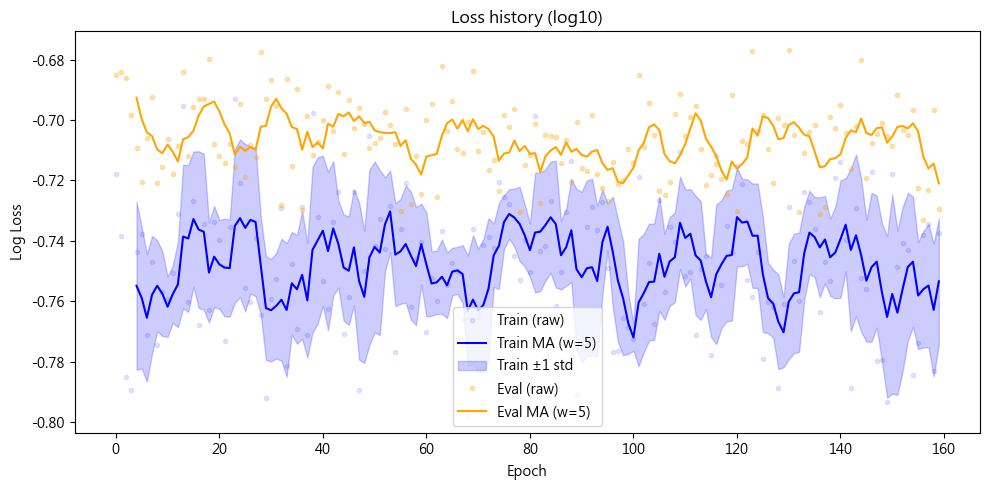

train


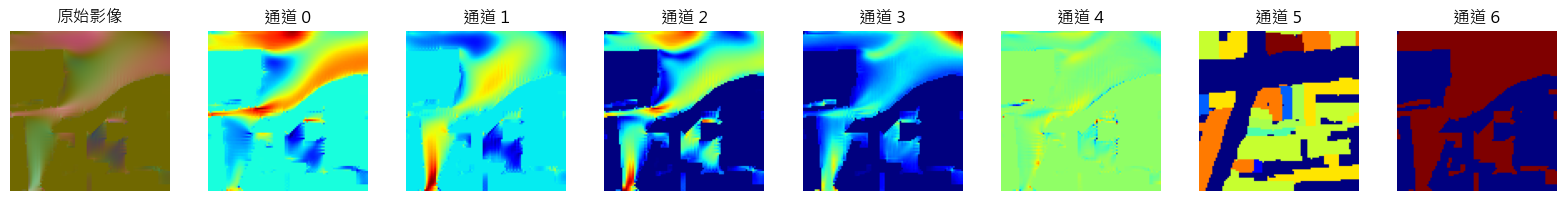

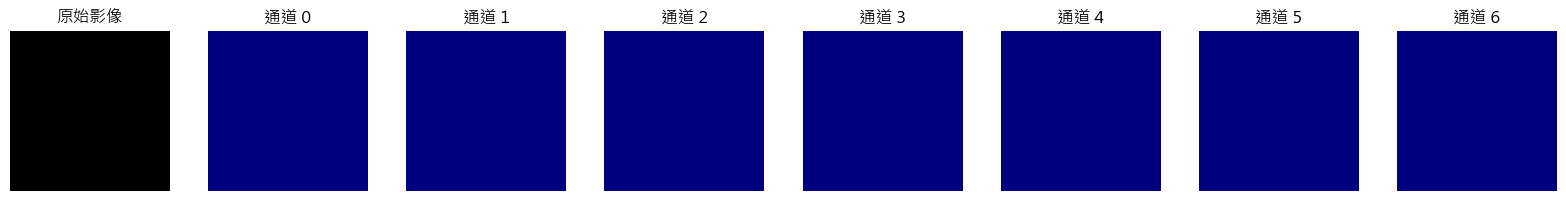

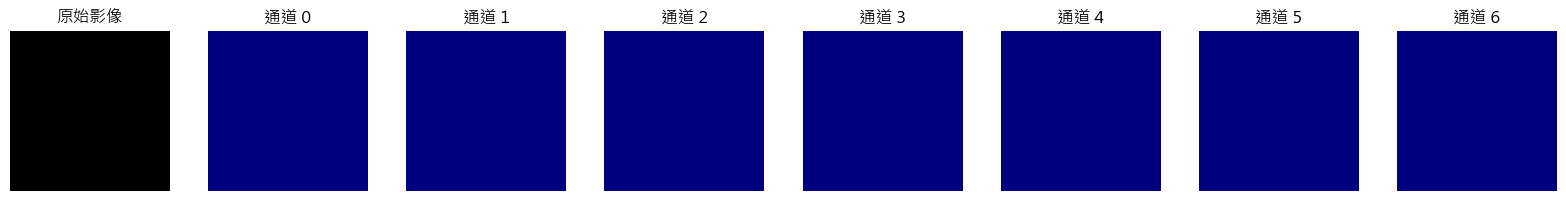

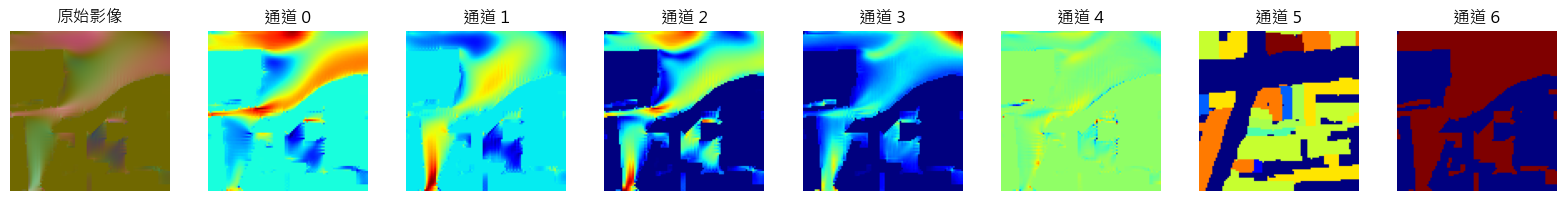

eval


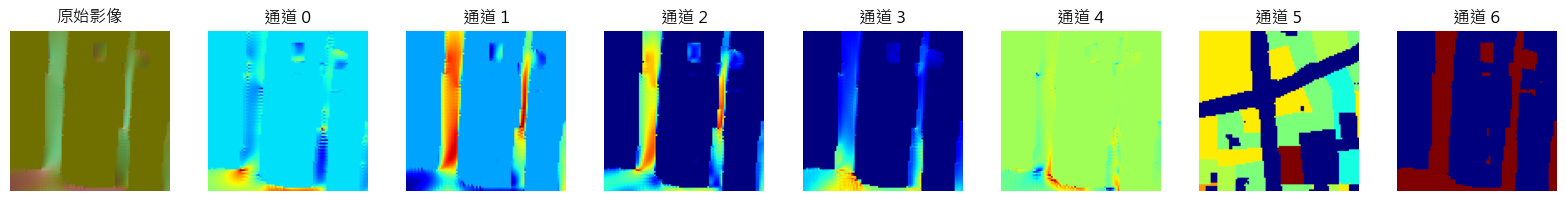

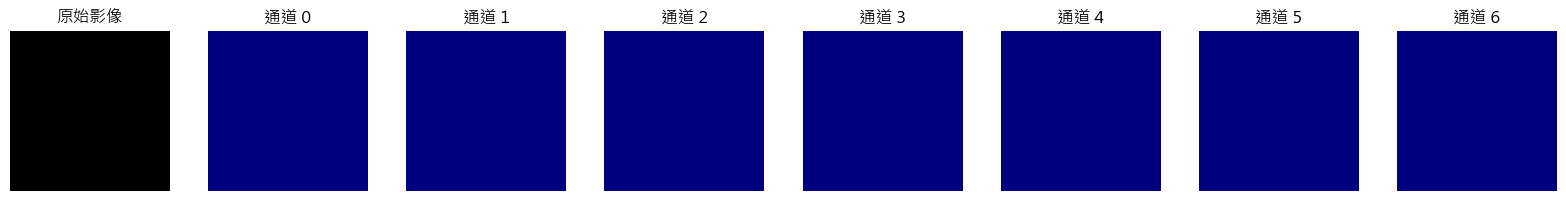

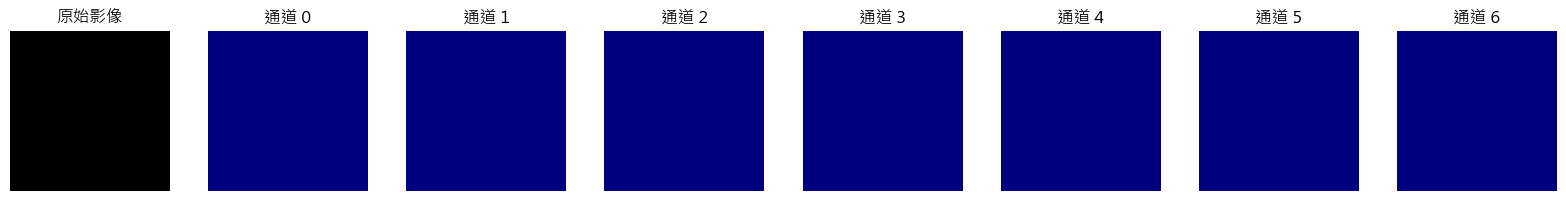

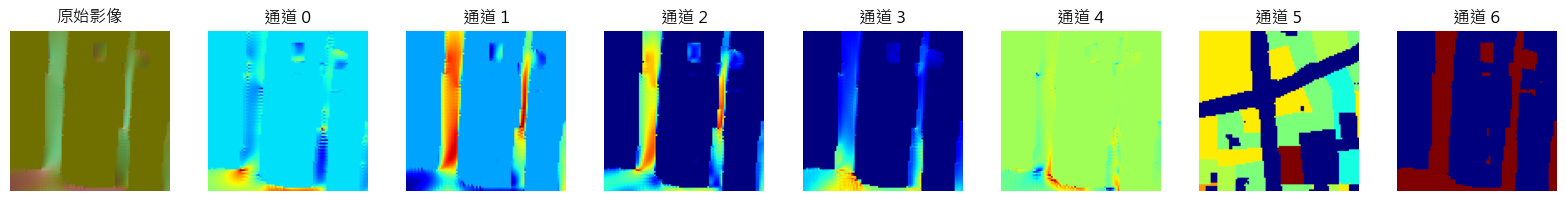

Epoch repeats:   0%|          | 0/1 [00:00<?, ?repeat/s]


KeyboardInterrupt: 

In [ ]:
model = CAModel(channel_n=CHANNELS).to(DEVICE)
optimizer = Optimizer.Adam(model.parameters(), lr=1e-4)



run_training(model, optimizer, loss_fn=custom_loss)

X_pred (B,C,H,W) shape = torch.Size([1, 20, 96, 96])
  channel 0: min=-12.309694, max=9.045758
  channel 1: min=-7.515831, max=11.121824
  channel 2: min=-5.328950, max=10.925607
  channel 3: min=-6.237623, max=6.615609
  channel 4: min=-16.835138, max=5.687065
  channel 5: min=-15.327520, max=5.330822
  channel 6: min=-50.438622, max=47.501049
  channel 7: min=-26.937649, max=6.618440
  channel 8: min=-18.601923, max=17.624767
  channel 9: min=-46.609509, max=34.290806
  channel 10: min=-28.287235, max=33.987362
  channel 11: min=-27.565014, max=37.052525
  channel 12: min=-42.584671, max=43.429050
  channel 13: min=-20.743053, max=32.165447
  channel 14: min=-26.369114, max=32.491867
  channel 15: min=-33.472473, max=7.801570
  channel 16: min=-50.913208, max=32.203041
  channel 17: min=-41.652580, max=46.458130
  channel 18: min=-21.765236, max=25.089561
  channel 19: min=-30.943743, max=19.685776


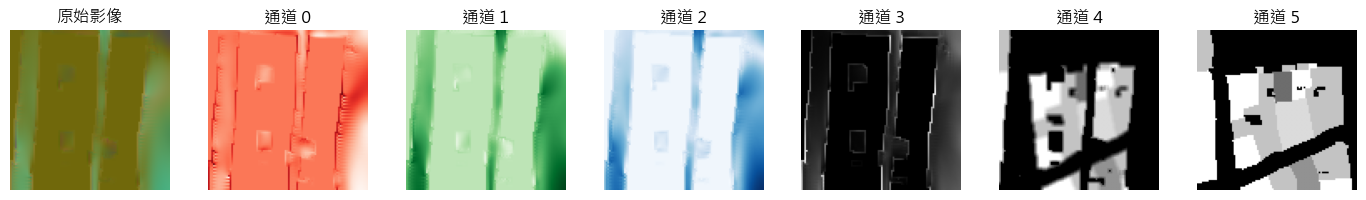

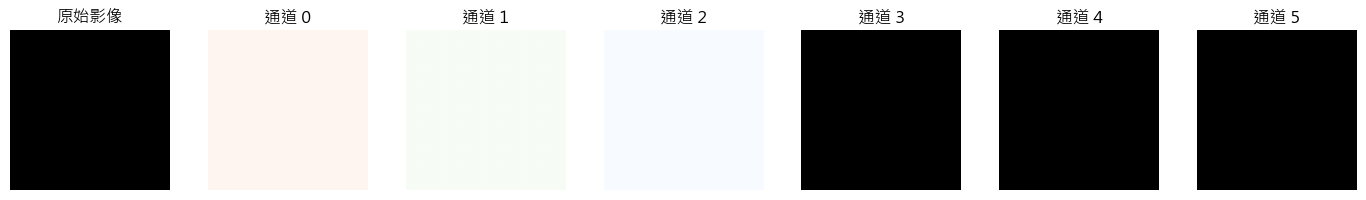

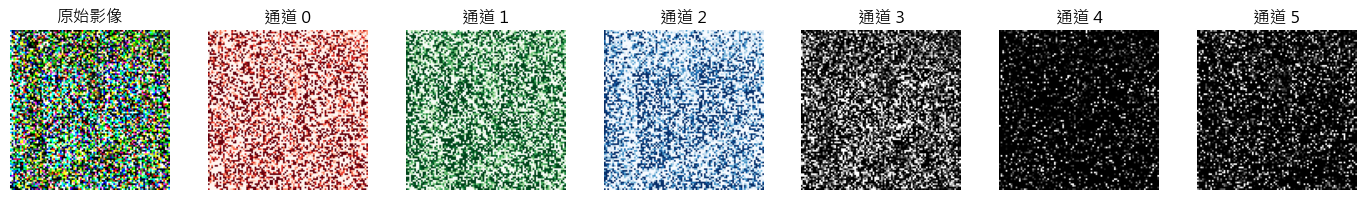

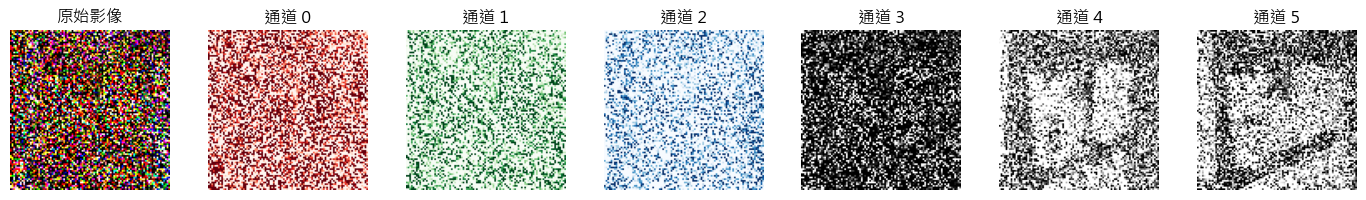

In [ ]:
# Example
Y_batch = create_epoch_pool(mode="test").to(DEVICE)
X_batch = init_X(Y_batch)
X_pred = model(Y_batch, n_times=10)
print_tensor_stats(X_pred, "X_pred")
error = Y_batch - X_pred
# Plot
plt_HWC_split_channels(to_HWC(Y_batch[0,:7,...]))
plt_HWC_split_channels(to_HWC(X_batch[0,:7,...]))
plt_HWC_split_channels(to_HWC(X_pred[0,:7,...]))
plt_HWC_split_channels(to_HWC(error[0,:7,...]))
